In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext, TriggerEvent, PositionsTracker
from qubx.pandaz.utils import *
import qubx.pandaz.ta as pta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers import PortfolioRebalancerTracker
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal

from qubx import QubxLogConfig
from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer
from qubx.core.metrics import chart_signals

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# Strat for signals testing

In [16]:
class StrategyForTracking(IStrategy):
    timeframe: str = "1Min"
    fast_period = 5
    slow_period = 12

    def on_fit(self, ctx: StrategyContext, fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)
            pos = ctx.positions[i.symbol].quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                signals.append(i.signal(+1, stop=ohlc[1].low))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                signals.append(i.signal(-1, stop=ohlc[1].high))

        return signals

    def tracker(self, ctx: StrategyContext) -> PositionsTracker:
        return PositionsTracker(FixedRiskSizer(1, 10_000, reinvest_profit=True))

In [17]:
from qubx.trackers.riskctrl import AtrRiskTracker

r = CsvStorageDataReader("../tests/data/csv")

QubxLogConfig.set_log_level("ERROR")

rep = simulate({
        "As Strategy 1": [
            StrategyForTracking(timeframe="15Min", fast_period=5, slow_period=25),
        ],

        "As Strategy 2": [
            StrategyForTracking(timeframe="15Min", fast_period=5, slow_period=25),
            AtrRiskTracker(10, 5, '15Min', 50, atr_smoother='kama', sizer=FixedRiskSizer(0.5))
        ]
    },
    r, 10000, [ "BINANCE.UM:BTCUSDT" ], 
    dict(type="ohlc", timeframe="15Min", nback=0),
    "-1Sec",
    "vip0_usdt", 
    "2024-01-01", "2024-01-05", 
)

  0%|          | 0/2 [00:00<?, ?it/s]

Simulating:   0%|          | 0/345600.0 [00:00<?, ?s/s]

Simulating:   0%|          | 0/345600.0 [00:00<?, ?s/s]

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
/As Strategy 1,97.803276,1.034999,1.823499,-0.001653,10.014674,1098.253455,3.293260,30.793275,0.886116,0.469516,310.438747,0.215374,224.611924,23.0
/As Strategy 2,66.305241,0.620007,6.382632,0.294818,1.512590,152.436250,18.643357,169.226913,2.124128,0.053585,45.232526,0.132892,40.683559,24.0


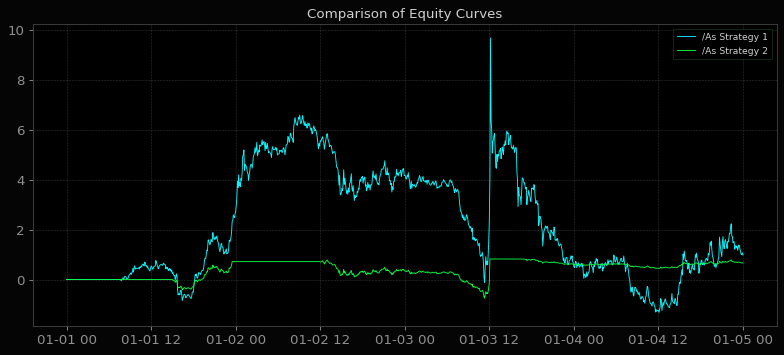

In [18]:
tearsheet(rep)

In [23]:
rep[1].executions_log

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-01 14:59:59.999,BTCUSDT,sell,-0.085,42645.55,1.812436,USDT
2024-01-01 15:44:59.999,BTCUSDT,buy,0.170,42885.65,3.645280,USDT
2024-01-01 23:27:36.000,BTCUSDT,sell,-0.085,44055.95,1.872378,USDT
2024-01-02 11:59:59.999,BTCUSDT,sell,-0.056,45486.75,1.273629,USDT
2024-01-02 14:14:59.999,BTCUSDT,buy,0.111,45815.35,2.542752,USDT
2024-01-02 14:59:59.999,BTCUSDT,sell,-0.109,45293.55,2.468498,USDT
2024-01-02 22:44:59.999,BTCUSDT,buy,0.105,44956.65,2.360224,USDT
2024-01-02 23:29:59.999,BTCUSDT,sell,-0.102,44999.05,2.294952,USDT
2024-01-03 00:59:59.999,BTCUSDT,buy,0.102,45168.15,2.303576,USDT


In [24]:
rep[0].signals_log

,instrument_id,exchange_id,signal,price,take,stop,group,comment
timestamp,,,,,,,,
2024-01-01 07:44:59.999,BTCUSDT,BINANCE.UM,1,None,None,42463.1,,
2024-01-01 14:59:59.999,BTCUSDT,BINANCE.UM,-1,None,None,42700.0,,
2024-01-01 15:44:59.999,BTCUSDT,BINANCE.UM,1,None,None,42666.6,,
2024-01-02 11:59:59.999,BTCUSDT,BINANCE.UM,-1,None,None,45614.9,,
2024-01-02 14:14:59.999,BTCUSDT,BINANCE.UM,1,None,None,45635.2,,
2024-01-02 14:59:59.999,BTCUSDT,BINANCE.UM,-1,None,None,45714.0,,
2024-01-02 22:44:59.999,BTCUSDT,BINANCE.UM,1,None,None,45070.0,,
2024-01-02 23:29:59.999,BTCUSDT,BINANCE.UM,-1,None,None,45042.9,,
2024-01-03 00:59:59.999,BTCUSDT,BINANCE.UM,1,None,None,44907.7,,


# Atr Tracker + generated signals

In [28]:
from qubx.trackers.riskctrl import AtrRiskTracker
QubxLogConfig.set_log_level("DEBUG")


r = MultiQdbConnector('xlydian-data')
rep = simulate(
    {
        "test0": [pd.Series(
            {
                "2024-01-01 10:00": 1,
                # "2024-01-02 12:00": 0,
                "2024-01-02 12:00": 1,
                "2024-01-03 10:00": -1,
                "2024-01-04 15:00": 0,

                "2024-01-04 16:00": 1,
                "2024-01-04 16:10": 2,
                "2024-01-05 17:00": 0,
            }, name='BTCUSDT'), 
                  AtrRiskTracker(5, 5, '5Min', 32, sizer=FixedRiskSizer(0.5))
            ],
    },

    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="1Min", nback=30), "-1Sec", "vip0_usdt", "2024-01-01", "2024-01-05", 
)

2024-08-03 13:52:55.257 [ 🐞 ] Connected to QuestDB at xlydian-data:8812
2024-08-03 13:52:55.257 [ 🐞 ] 2024-01-01 00:00:00 Initiating simulated trading for binance.um for 10000 x 1.0 in USDT...
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedData.binance.um initialized


Simulating:   0%|          | 0/406800.0 [00:00<?, ?s/s]

2024-01-01 00:00:00.000 [ 🐞 ] Using pre-generated signals:
 7
2024-01-01 00:00:00.000 [ 🐞 ] Triggering strategy on every 1Min bar after 
2024-01-01 00:00:00.000 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 30} for 
	['BTCUSDT'] 
2024-01-01 00:00:00.000 [ 🐞 ] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation started at 2024-01-01
2024-01-01 00:00:00.000 [ ℹ️ ] Initializing chunks for each loader
2024-01-01 00:00:00.000 [ 🐞 ] Triggering strategy on every 1Min bar after 
2024-01-01 00:00:00.000 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 30} for 
	['BTCUSDT'] 
2024-01-01 00:00:00.000 [ 🐞 ] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation started at 2024-01-01
2024-01-01 00:00:00.000 [ ℹ️ ] Initializing chunks for each loader
2023-12-

In [ ]:
tearsheet(rep, False)

In [29]:
rep[0].executions_log

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-01 10:00:00.001,BTCUSDT,buy,0.237,42688.85,5.058629,USDT
2024-01-01 18:01:36.000,BTCUSDT,sell,-0.237,42908.35,5.084639,USDT
2024-01-02 12:00:00.001,BTCUSDT,buy,0.100,45486.85,2.274343,USDT
2024-01-02 15:17:36.000,BTCUSDT,sell,-0.100,44932.95,2.246647,USDT
2024-01-03 10:00:00.001,BTCUSDT,sell,-0.115,45378.55,2.609267,USDT
2024-01-03 11:08:36.000,BTCUSDT,buy,0.115,44928.55,2.583392,USDT
2024-01-04 16:00:00.001,BTCUSDT,buy,0.072,44050.45,1.585816,USDT
2024-01-04 16:10:00.001,BTCUSDT,sell,-0.002,43899.65,0.043900,USDT
2024-01-04 20:38:36.000,BTCUSDT,sell,-0.070,44840.75,1.569426,USDT


In [30]:
rep[0].signals_log

,instrument_id,exchange_id,signal,target_position,price,take,stop,group,comment
timestamp,,,,,,,,,
2024-01-01 10:00:00.001,BTCUSDT,BINANCE.UM,1,0.237494,None,42899.381250,42478.318750,,
2024-01-01 18:01:36.000,BTCUSDT,BINANCE.UM,0,0.000000,None,NaN,NaN,Risk Manager,Take triggered
2024-01-02 12:00:00.001,BTCUSDT,BINANCE.UM,1,0.100684,None,45988.115625,44985.584375,,
2024-01-02 15:17:36.000,BTCUSDT,BINANCE.UM,0,0.000000,None,NaN,NaN,Risk Manager,Stop triggered
2024-01-03 10:00:00.001,BTCUSDT,BINANCE.UM,-1,-0.115511,None,44946.471875,45810.628125,,
2024-01-03 11:08:36.000,BTCUSDT,BINANCE.UM,0,0.000000,None,NaN,NaN,Risk Manager,Take triggered
2024-01-04 15:00:00.001,BTCUSDT,BINANCE.UM,0,0.000000,None,NaN,NaN,,
2024-01-04 16:00:00.001,BTCUSDT,BINANCE.UM,1,0.072648,None,44743.996875,43356.903125,,
2024-01-04 16:10:00.001,BTCUSDT,BINANCE.UM,2,0.069122,None,44626.984375,43172.515625,,


In [31]:
ohlc_pd1 = r.read('BINANCE.UM:BTCUSDT', '2024-01-01', '2024-02-05', AsPandasFrame())
ohlc_pd = ohlc_resample(ohlc_pd1, '5Min')

In [ ]:
chart_signals(rep[0], "BTCUSDT", ohlc_pd1, overlay=[
    ohlc_pd.close - 5*pta.atr(ohlc_pd, 32),
    ohlc_pd.close + 5*pta.atr(ohlc_pd, 32),
], info=0)